# BST234 Final Project

In [22]:
import numpy as np
import time
import fbpca 
import scipy as sp
import scipy.linalg
from scipy import sparse
import scipy.sparse.linalg
import random
import matplotlib.pyplot as plt
import warnings

In [4]:
def prep_data():
    x = np.loadtxt("simulated_genos", delimiter=" ", dtype="float32")
    y = np.array([[1] * 10000 + [0] * 10000], dtype="float32")
    y_c = y - 0.5
    return x, y, y_c

x, y, y_c = prep_data()

In [5]:
n = 20000
X = x[:,:]
print("X shape:", X.shape)
print("Rank of X:", np.linalg.matrix_rank(X))
print ("Number of 1:",np.sum(x))
n = X.shape[0]
p = X.shape[1]

X shape: (20000, 50)
Rank of X: 50
Number of 1: 953.0


Convert X to CSR format

In [6]:
X_sparse = sp.sparse.csr_matrix(X)

# Eigenvalue Computation

This standard implementation of scipy.sparse.eigvals is a wrapper of the software [**ARPACK**](http://www.caam.rice.edu/software/ARPACK/
).
The method is Implicitly Restarted Arnoldi Methods. See detail of this in [ARPACK User Guide](http://li.mit.edu/Archive/Activities/Archive/CourseWork/Ju_Li/MITCourses/18.335/Doc/ARPACK/Lehoucq97.pdf).

Calculate $XX^T$

In [7]:
XX_t = X  @ X.T
#np.linalg.matrix_rank(XX_t)

In [8]:
type(XX_t)
print(XX_t.shape)
print(XX_t)
print("Sum of XX^T", np.sum(XX_t))

(20000, 20000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Sum of XX^T 23633.0


Use sp.sparse.linalg.eigs to calculate eigenvalue

In [17]:
%%time
XX_t_sparse = X_sparse @ X_sparse.T
ev_sparse = sparse.linalg.eigs(XX_t_sparse, k=50)
print("Sparse Eigenvalue Computation Time:")

Sparse Eigenvalue Computation Time:
Wall time: 329 ms


See the calculation result.

In [11]:
ev_sparse = np.real(ev_sparse[0])
print(sorted(ev_sparse, reverse=True))

[40.000046, 38.083164, 37.10237, 37.066376, 37.00003, 33.047565, 31.164595, 29.129011, 29.071096, 29.039923, 29.000004, 28.000025, 27.657082, 26.039421, 25.528225, 25.03124, 25.000023, 24.000048, 23.999977, 22.000013, 21.933672, 21.000053, 20.6858, 20.000004, 20.000004, 19.80418, 17.827843, 16.947348, 16.0, 15.999998, 14.928926, 12.999996, 12.000003, 11.952488, 11.000006, 10.999992, 10.000006, 10.000001, 10.0, 8.999991, 8.000004, 7.0000024, 7.0, 6.9999948, 6.0000076, 5.000003, 4.0000076, 3.9999995, 3.9600668, 1.0000091]


In [25]:
sum(ev_sparse / 4)

238.2501277923584

# Singular Value Decomposition (SVD)
Computing the Singular Value Decomposition (SVD) is a fundamental linear algebra primitive, ubiquitous in machine learning, statistics, signal processing, and other fields. Formally, the SVD of a real m × n matrix A is a factorization of the form A = U Σ Vᵀ, where U is an m × m orthogonal matrix of left singular vectors, Σ is an m × n diagonal matrix of singular values, and Vᵀ is an n × n orthogonal matrix of right singular vectors.

The SVD provides a roadmap to computing a low-rank approximation for A– that is, finding a matrix Aᵣ with rank r < m, n such that ||Aᵣ – A|| is minimized. Given A = U Σ Vᵀ, we can approximate A by the following procedure:

Sort the nonzero elements of Σ in decreasing order;
Take the first r elements of Σ (say Σᵣ, an r × r diagonal matrix), the corresponding columns of U (Uᵣ, an m × r orthogonal matrix) and the corresponding columns of V (Vᵣ, an n × r orthogonal matrix);
Take Aᵣ = Uᵣ Σᵣ Vᵣᵀ.

Use sp.linalg.svdvals to calculate singular value

In [28]:
start_time = time.clock()
np_SVD_result = sp.linalg.svdvals(X[:n,:])
end_time = time.clock()
print("np SVD time", end_time - start_time)
print("X SV:", np_SVD_result, len(np_SVD_result))

np SVD time 0.022891927132604906
X SV: [6.324555  6.171154  6.091167  6.0882163 6.0827622 5.7486973 5.5825267
 5.3971276 5.3917594 5.388871  5.385164  5.2915025 5.258997  5.102881
 5.052542  5.0031204 4.9999995 4.898985  4.8989787 4.6904163 4.683336
 4.582577  4.5481615 4.472136  4.472136  4.4501877 4.2222996 4.116715
 4.0000014 4.        3.863798  3.6055512 3.4641018 3.4572375 3.3166246
 3.316624  3.1622791 3.162278  3.1622767 3.0000017 2.8284268 2.6457512
 2.6457512 2.6457512 2.4494898 2.2360685 2.        2.        1.9899907
 1.       ] 50


## irlbpy (SVD)

This implementation is modified from module **irlbpy**. See link below.

[IRLB method](https://epubs.siam.org/doi/abs/10.1137/04060593X)

In [12]:
def mult(A,x,t=False):
  if(sparse.issparse(A)):
    m = A.shape[0]
    n = A.shape[1]
    if(t):
      return(sparse.csr_matrix(x).dot(A).transpose().todense().A[:,0])
    return(A.dot(sparse.csr_matrix(x).transpose()).todense().A[:,0])
  if(t):
    return(x.dot(A))
  return(A.dot(x))

def orthog(Y,X):
  dotY = mult(X,Y,t=True)
  return (Y - mult(X,dotY))


def invcheck(x):
  eps2  = 2*np.finfo(np.float).eps
  if(x>eps2):
    x = 1/x
  else:
    x = 0
  return(x)

def irlb(A,n,tol=0.0001,maxit=50):
  nu     = n
  m      = A.shape[0]
  n      = A.shape[1]
  m_b    = min((nu+20, 3*nu, n))
  mprod  = 0
  it     = 0
  j      = 0
  k      = nu
  smax   = 1
  ifsparse = sparse.issparse(A)

  V  = np.zeros((n,m_b))
  W  = np.zeros((m,m_b))
  F  = np.zeros((n,1))
  B  = np.zeros((m_b,m_b))

  V[:,0]  = np.random.randn(n)
  V[:,0]  = V[:,0]/np.linalg.norm(V)

  while(it < maxit):
    if(it>0): j=k
    W[:,j] = mult(A,V[:,j])
    mprod+=1
    if(it>0):
      W[:,j] = orthog(W[:,j],W[:,0:j]) # NB W[:,0:j] selects columns 0,1,...,j-1
    s = np.linalg.norm(W[:,j])
    sinv = invcheck(s)
    W[:,j] = sinv*W[:,j]
    while(j<m_b):
      F = mult(A,W[:,j],t=True)
      mprod+=1
      F = F - s*V[:,j]
      F = orthog(F,V[:,0:j+1])
      fn = np.linalg.norm(F)
      fninv= invcheck(fn)
      F  = fninv * F
      if(j<m_b-1):
        V[:,j+1] = F
        B[j,j] = s
        B[j,j+1] = fn 
        W[:,j+1] = mult(A,V[:,j+1])
        mprod+=1
        W[:,j+1] = W[:,j+1] - fn*W[:,j]
        W[:,j+1] = orthog(W[:,j+1],W[:,0:(j+1)])
        s = np.linalg.norm(W[:,j+1])
        sinv = invcheck(s) 
        W[:,j+1] = sinv * W[:,j+1]
      else:
        B[j,j] = s
      j+=1
    S    = np.linalg.svd(B)
    R    = fn * S[0][m_b-1,:] 
    if(it<1):
      smax = S[1][0]
    else:
      smax = max((S[1][0],smax))

    conv = sum(np.abs(R[0:nu]) < tol*smax)
    if(conv < nu):
      k = max(conv+nu,k)
      k = min(k,m_b-3)
    else:
      break
    V[:,0:k] = V[:,0:m_b].dot(S[2].transpose()[:,0:k])
    V[:,k] = F 
    B = np.zeros((m_b,m_b))
    for l in range(0,k):
      B[l,l] = S[1][l]
    B[0:k,k] = R[0:k]
    W[:,0:k] = W[:,0:m_b].dot(S[0][:,0:k])
    it+=1

  U = W[:,0:m_b].dot(S[0][:,0:nu])
  V = V[:,0:m_b].dot(S[2].transpose()[:,0:nu])
  return((U,S[1][0:nu],V,it,mprod))

Check the result of **irlbpy**

In [32]:
%%time
result_irlb = irlb(X, 50)
print("Time of irlbpy:")

Time of irlbpy:
Wall time: 1.17 s


In [33]:
result_irlb[1]

array([6.32455532, 6.17115224, 6.09116741, 6.08821591, 6.08276253,
       5.74869651, 5.58252703, 5.39712732, 5.39175925, 5.38887151,
       5.38516481, 5.29150262, 5.2589973 , 5.1028813 , 5.05254332,
       5.00312107, 5.        , 4.89897949, 4.89897949, 4.69041576,
       4.68333503, 4.58257569, 4.54816118, 4.47213595, 4.47213595,
       4.45018781, 4.22230026, 4.11671501, 4.        , 4.        ,
       3.86379764, 3.60555128, 3.46410162, 3.45723711, 3.31662479,
       3.31662479, 3.16227766, 3.16227766, 3.16227766, 3.        ,
       2.82842712, 2.64575131, 2.64575131, 2.64575131, 2.44948974,
       2.23606798, 2.        , 2.        , 1.9899909 , 1.        ])

The result is quite fine, although it is still time consuming. In order to speed up, try the method **RSVD**.

## Randomized Matrix Approximation

here, we’ll focus on some modern randomized matrix approximation techniques, developed in (amongst others) in Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions, a 2009 paper by Nathan Halko, Per-Gunnar Martinsson and Joel A. Tropp. 
https://arxiv.org/abs/0909.4061

## 1. FBPCA package for randomized SVD
This package is developed by facebook research.
Relavant links:
http://fbpca.readthedocs.io/en/latest/


In [24]:
print("FBPCA Computation Time:")
%time sig_rsvd_fbpca = fbpca.pca(x,50,True)[1]
eig_rsvd_fbpca = sig_rsvd_fbpca ** 2
print(eig_rsvd_fbpca)

FBPCA Computation Time:
Wall time: 38.1 ms
[40.00001   38.083153  37.10235   37.066402  37.000008  33.04754
 31.164598  29.128998  29.071054  29.039928  28.999985  28.000004
 27.65704   26.039398  25.528193  25.031229  25.000006  24.000053
 23.999983  22.00001   21.933638  21.000013  20.685785  20.000006
 20.000006  19.804184  17.827847  16.947346  16.        15.999994
 14.928925  13.000002  11.999993  11.9524975 11.000004  10.999996
 10.000007  10.000003  10.         9.000003   7.9999986  7.000001
  7.000001   6.9999995  6.000003   5.         4.         4.
  3.960063   1.       ]


## Randomized SVD
Here is our own implementation of randomized SVD. After reduce the dimention, we use np.linalg.svd (the svd function in numpy) to conduct svd on a smaller scale matrix

In [21]:
#randomized SVD
def randomized_svd(M, k=10):
    m, n = M.shape
    transpose = False
    if m < n:
        transpose = True
        M = M.T
        
    rand_matrix = np.random.normal(size=(M.shape[1], k))  # short side by k
    Q, _ = np.linalg.qr(M @ rand_matrix, mode='reduced')  # long side by k
    smaller_matrix = Q.T @ M                              # k by short side
    U_hat, s, V = np.linalg.svd(smaller_matrix, full_matrices=False)
    U = Q @ U_hat
    
    if transpose:
        return V.T, s.T, U.T
    else:
        return U, s, V
print("RSVD Computation Time:")    
%time sig_rsvd = randomized_svd(x,50)[1]
eig_rsvd = sig_rsvd ** 2
print(eig_rsvd)

RSVD Computation Time:
Wall time: 139 ms
[40.         38.08311991 37.10232046 37.06637298 37.         33.04751155
 31.16460799 29.12898331 29.07106781 29.0399362  29.         28.
 27.65705259 26.03939761 25.52819398 25.03122049 25.         24.
 24.         22.         21.93362702 21.         20.68577012 20.
 20.         19.80417152 17.82781952 16.9473425  16.         16.
 14.92893219 13.         12.         11.95248845 11.         11.
 10.         10.         10.          9.          8.          7.
  7.          7.          6.          5.          4.          4.
  3.9600638   1.        ]


# Comparsion of different methods
Here, we compare the randomized SVD methods (approximate methods) to the exact methods (scipy's), in terms of computing time and accuracy.

compare approximate methods to exact method's eigenvalue

In [39]:
# compare approximate methods to exact method's eigen
eig_rsvd = list(eig_rsvd)
eig_exact = eig_exact_sorted = np_SVD_result ** 2
def err_cal(l):
    total_error = 0
    for i in range(len(eig_rsvd)):
        error = abs(eig_rsvd[i]-eig_exact_sorted[i])
        total_error += error
    mean_error = total_error/len(eig_rsvd)
    return (total_error, mean_error)

In [35]:
err_cal(eig_rsvd)

(0.00025952831847830815, 5.190566369566163e-06)

In [36]:
err_cal(list(result_irlb[1] ** 2))

(0.00025952831847830815, 5.190566369566163e-06)

#### Compute P-value, by Monte Carlo simulation, the distribution of Q

The p-value is: 0.782043


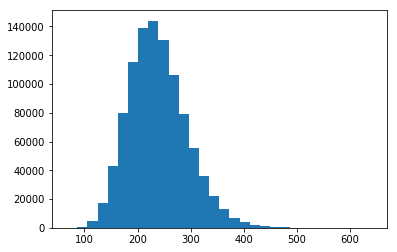

In [56]:
%matplotlib inline


def generate_Q(eig, N = 1000000):
    Q_distribution = []
    for i in range(N):
        #generate 50 chi-square r.v
        sample = np.random.chisquare(1, size=50)
        Q_stat = np.sum(eig * sample)/4
        Q_distribution.append(Q_stat)
    return Q_distribution
  
Q_distribution = generate_Q(eig = eig_rsvd)
#print (Q_distribution)
plt.hist(Q_distribution, bins = 30)
q = 223.25
def inverse_percentile(arr, num):
    arr = sorted(arr)
    i_arr = [i for i, x in enumerate(arr) if x > num]
    return i_arr[0] / len(arr) if len(i_arr) > 0 else 1


def p_cal(q):
    q = 223.25
    abs_Q_distribution = abs(Q_distribution - np.average(Q_distribution))
    q_abs = abs(q-np.average(Q_distribution))
    p = 1- inverse_percentile(abs_Q_distribution, q_abs)
    return p



print ("The p-value is:", p_cal(q))

In [53]:
sum(eig_rsvd) / 4

238.25000000000017

### benchmark, comparsion of computing time
Here are our steps to compute the computing time, with different size of K*K matrix:
1. generate 50 random eigen value according to N(real eigen value,0.1), accordingly.
2. generate a random K*50, orthogonal matrix X, K >50, using the scipy function, scipy.linalg.orth
3. compute $X \Lambda  X^{T}$ , where $ \Lambda  $ is the 50*50 diagonal matrix with 50 eigenvalues, accordingly.
4. using  eigen methods on $X \Lambda  X^{T}$, and the computing time, with average of 1000 times of computing for each K

In [44]:
#generate 50 random eigen value according to N(real eigen value,0.1)

print (eig_exact)
random_eigen = [0]*50
for i in range(50):
    random_eigen[i]= float(np.random.normal(eig_exact[i], 0.1, 1))
print (random_eigen)

#generate K*50, orthogonal matrix, K >50
import scipy
K = 100
a = np.random.random(size=(K, 50))
q = scipy.linalg.orth(a)
print (q)
I = np.identity(50)
E = I*random_eigen
M = q @ E @ q.T
print (M)
import time

X_sparse = sparse.csr_matrix(q)
X_T_sparse = sparse.csr_matrix.transpose(X_sparse)
XX = X_sparse@E@X_T_sparse
start_time = time.clock()
eig_2 = scipy.sparse.linalg.eigsh(XX,k=50)
end_time = time.clock()
eig_2 = eig_2[0]
print (eig_2)
print (end_time - start_time)

[39.999996  38.08314   37.102314  37.06638   36.999996  33.04752
 31.164604  29.128986  29.07107   29.039932  28.999989  27.999998
 27.65705   26.039394  25.528183  25.031214  24.999996  24.000053
 23.999992  22.000006  21.933634  21.000013  20.685774  20.
 20.        19.80417   17.827814  16.947342  16.000011  16.
 14.928934  13.        12.000001  11.952491  10.999999  10.999994
 10.00001   10.000002   9.999994   9.0000105  7.9999986  6.9999995
  6.9999995  6.9999995  6.0000005  5.0000024  4.         4.
  3.960063   1.       ]
[40.029465640185556, 38.19806113389817, 37.00834899817658, 37.1353937571005, 36.77327588384245, 32.94758212131358, 31.367384298945225, 29.075385632093887, 28.900816611831765, 29.15910661260106, 29.066421787548705, 28.167834968695214, 27.66862776067179, 26.06055743141596, 25.57330077161648, 24.995846977218182, 24.8202624390388, 24.056472305019376, 24.03920850411316, 22.026103805716573, 21.935623338198457, 21.127844482256673, 20.655710932127466, 19.866093253498846

Here are the functions to test average running time for computing eigenvalues for different methods

In [45]:
# function to test average running time for computing eigen
#function 1, testing the computing time of scipy function
def test_eigen_1(K):
    random_eigen = [0]*50
    for i in range(50):
        random_eigen[i]= float(np.random.normal(eig_exact[i], 0.1, 1))
    a = np.random.random(size=(K, 50))
    q = scipy.linalg.orth(a)
    I = np.identity(50)
    E = I*random_eigen
    M = q @ E @ q.T
    X_sparse = sparse.csr_matrix(q)
    X_T_sparse = sparse.csr_matrix.transpose(X_sparse)
    XX = X_sparse@E@X_T_sparse
    time_list = []
    for j in range(100):
        start_time = time.clock()
        eig_2 = lg.eigsh(XX,k=50)
        end_time = time.clock()
        time_list.append(end_time-start_time)
    average_time = sum(time_list)/1000
    eig_2 = eig_2[0]
    return (average_time, eig_2)

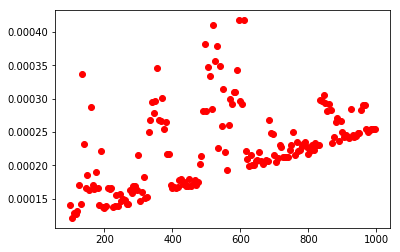

In [46]:
#function 2, testing the computing time of randomized SVD function
def test_rsvd_1(K):
    random_eigen = [0]*50
    for i in range(50):
        random_eigen[i]= float(np.random.normal(eig_exact[i], 0.1, 1))
    a = np.random.random(size=(K, 50))
    q = scipy.linalg.orth(a)
    I = np.identity(50)
    E = I*np.sqrt(random_eigen)
    X_sparse = sparse.csr_matrix(q)   
    XX = X_sparse@E
    time_list = []
    for j in range(100):
        start_time = time.clock()
        eig_2 = randomized_svd(XX,50)
        end_time = time.clock()
        time_list.append(end_time-start_time)
    average_time = sum(time_list)/1000
    eig_2 = eig_2[0]
    return (average_time, eig_2)


#print (test_eigen_1(1000))
#compute list of runing time vs. K
k_list = range(100,1000,5)
time_list = [test_rsvd_1(k)[0] for k in k_list]
#print (time_list)
import matplotlib.pyplot as plt
plt.plot(k_list, time_list, 'ro')
plt.show()